## 1 Warmup

In [140]:
import numpy as np
import matplotlib.pyplot as plt

In [122]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [123]:
data_all = sample_data()
data_trn = data_all[:8000]
data_val = data_all[8000:]

Derivative for softmax where $$p = \text{softmax}(\theta), y = \text{one_hot}(x)$$:
$$\nabla_{\theta_x} p_\theta(x) = p_\theta(x)(1-p_\theta(x))$$
$$\nabla_{\theta_{x^\prime}} p_\theta(x) = -p_\theta(x)p_\theta(x^\prime), x \neq x^\prime$$
$$J(\theta) = \frac{1}{n} \sum_i -\log p_\theta(x^{(i)})$$
$$\nabla_{\theta_j} J(\theta) = \frac{1}{n} [\sum_i p_\theta(x^{(i)}) - \sum_i I(j=x^{(i)})] = \frac{1}{n} - \frac{1}{n}\sum_i I(j=x^{(i)})$$

In [300]:
class Solver1():
    def __init__(self, input_range=100, lr=5e-4, batch_size=500, num_epochs=10000, log_every_epoch=50):
        self.lr = lr
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.log_every_epoch = log_every_epoch
        self.theta = np.zeros(input_range)
    
    def compute_loss(self, batch):
        theta_entries = self.theta[batch]
        stab = np.max(theta_entries) # stablizer
        probs = np.exp(theta_entries - stab) / np.sum(np.exp(self.theta - stab)) # array of p_\theta(x^{(i)}) 
        loss = np.mean(-np.log(probs))
        return loss
    
    def update(self, batch):
        n = len(batch)
        gradient = np.ones(len(self.theta)) * 1/n
        unique, counts = np.unique(batch, return_counts=True)
        for j, count in zip(unique, counts):
            gradient[j] -= count/n
        self.theta -= self.lr * gradient
    
    def train(self, data_trn, data_val):
        loss_trn = []
        loss_val = []
        for epoch in range(self.num_epochs):
            np.random.shuffle(data_trn)
            loss_trn_batch = []
            for batch in np.array_split(data_trn, np.ceil(len(data_trn)/self.batch_size)):
                self.update(batch)
                loss = self.compute_loss(batch)
                loss_trn_batch.append(loss)
            if epoch % self.log_every_epoch == 0:
                loss_trn.append(np.mean(loss_trn_batch))
                loss_val.append(self.compute_loss(data_val))
                print("loss at epoch {}: {}, {}".format(epoch, loss_trn[-1], loss_val[-1]))
        return loss_trn, loss_val

In [150]:
solver = Solver1()
loss_trn, loss_val = solver.train(data_trn, data_val)

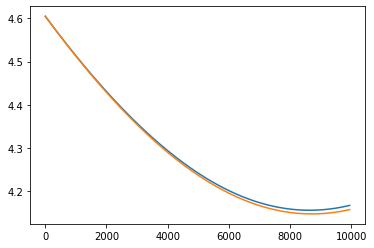

In [151]:
epochs = list(range(0, solver.num_epochs, solver.log_every_epoch))
plt.plot(epochs, loss_trn)
plt.plot(epochs, loss_val)

(array([ 24., 118., 343., 333., 160.,  24.,   8., 234., 677.,  79.]),
 array([ 1. , 10.5, 20. , 29.5, 39. , 48.5, 58. , 67.5, 77. , 86.5, 96. ]),
 <a list of 10 Patch objects>)

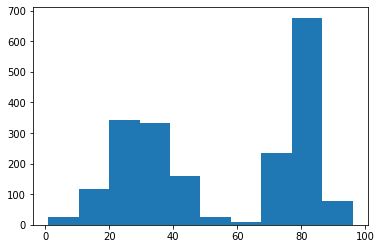

In [152]:
plt.hist(data_val)

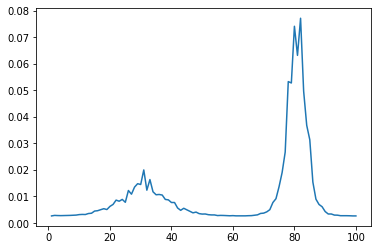

In [153]:
probs = np.exp(solver.theta - np.max(solver.theta))
probs /= np.sum(probs)
plt.plot(range(1, 101), probs)

(array([ 61.,  86., 205., 226.,  81.,  60.,  57., 550., 617.,  57.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <a list of 10 Patch objects>)

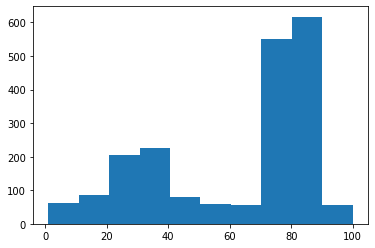

In [154]:
data_generated = np.random.choice(range(1, 101), size=2000, replace=True, p=probs)
plt.hist(data_generated)

## 2 Two-dimensional data

### 2.1 MLP

In [155]:
distribution = np.load('./distribution.npy')

In [168]:
data_all = np.random.choice(range(200*200), size=100000, replace=True, p=distribution.flatten())

In [169]:
data_all = [(x//200, x%200) for x in data_all]
data_trn = data_all[:8000]
data_val = data_all[8000:]

In [312]:
class MLP():
    def __init__(self, input_dim=200, hid_dim=200, output_dim=200, num_epochs=800, batch_size=400, lr=5e-4, log_every_epoch=10):
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.log_every_epoch = log_every_epoch
        self.W1 = np.random.randn(input_dim, hid_dim)
        self.b1 = np.random.randn(hid_dim)
        self.W2 = np.random.randn(hid_dim, output_dim)
        self.b2 = np.random.randn(output_dim)
    
    def softmax(self, logits):
        probs = np.exp(logits - np.max(logits, axis=-1).reshape(len(logits), 1))
        probs /= np.sum(probs, axis=-1).reshape(len(logits), 1)
        return probs
    
    def one_hot(self, x, total=200):
        rt = np.zeros(total)
        rt[x] = 1
        return rt
    
    def split(self, batch):
        batch_x = np.array([self.one_hot(x) for x, y in batch])
        batch_y = np.array([y for x, y in batch])
        return batch_x, batch_y
        
    def forward(self, batch_x):
        hidden = batch_x.dot(self.W1) + self.b1
        hidden_activated = np.tanh(hidden)
        logits = hidden_activated.dot(self.W2) + self.b2
        out = self.softmax(logits)
        rec = [batch_x, hidden, hidden_activated]
        return out, rec
    
    def compute_loss(self, batch_y, out):
        probs = out[range(len(batch_y)), batch_y]
        return np.mean(-np.log(probs))
    
    def backward(self, batch_y, out, rec):
        batch_x, hidden, hidden_activated = rec
        dlogits = out.copy()
        dlogits[range(len(batch_y)), batch_y] -= 1
        dlogits = dlogits / len(batch_y)
        db2 = np.sum(dlogits, axis=0)
        dW2 = hidden_activated.T.dot(dlogits)
        dhidden_activated = dlogits.dot(self.W2.T)
        dhidden = dhidden_activated * (1-hidden_activated**2)
        db1 = np.sum(dhidden, axis=0)
        dW1 = batch_x.T.dot(dhidden)
#         assert dW2.shape == self.W2.shape
#         assert db2.shape == self.b2.shape
#         assert dW1.shape == self.W1.shape
#         assert db1.shape == self.b1.shape
        return dW2, db2, dW1, db1
    
    def update(self, batch):
        batch_x, batch_y = self.split(batch)
        out, rec = self.forward(batch_x)
        dW2, db2, dW1, db1 = self.backward(batch_y, out, rec)
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        return self.compute_loss(batch_y, out)
    
    def train(self, data_trn, data_val):
        data_val_x, data_val_y = self.split(data_val)
        loss_trn = []
        loss_val = []
        for epoch in range(self.num_epochs):
            np.random.shuffle(data_trn)
            loss_trn_batch = []
            for batch in np.array_split(data_trn, np.ceil(len(data_trn)/self.batch_size)):
                loss = self.update(batch)
                loss_trn_batch.append(loss)
            if epoch % self.log_every_epoch == 0:
                loss_trn.append(np.mean(loss_trn_batch))
                out, _ = self.forward(data_val_x)
                loss_val.append(self.compute_loss(data_val_y, out))   
                print("loss at epoch {}: {}, {}".format(epoch, loss_trn[-1], loss_val[-1]))
        return loss_trn, loss_val

In [313]:
mlp = MLP()
loss_trn, loss_val = mlp.train(data_trn, data_val)

loss at epoch 0: 28.54135034335958, 28.33199193532397
loss at epoch 10: 27.803540368401798, 27.60846027395569
loss at epoch 20: 27.27326837801177, 27.08505569446608
loss at epoch 30: 26.855671154330658, 26.67212915351918
loss at epoch 40: 26.507571735581386, 26.327889559803044
loss at epoch 50: 26.20676645614845, 26.030594452429202
loss at epoch 60: 25.940502817672204, 25.76776739886843
loss at epoch 70: 25.70078631803409, 25.531530910324516
loss at epoch 80: 25.48206353481289, 25.316377129737926
loss at epoch 90: 25.280173863863073, 25.118105096935093
loss at epoch 100: 25.09184278012076, 24.93342010196987
loss at epoch 110: 24.914590748916137, 24.759811095165873
loss at epoch 120: 24.74658211290889, 24.59544307805305
loss at epoch 130: 24.586534288066225, 24.43901073392325
loss at epoch 140: 24.433510017785014, 24.28956315912235
loss at epoch 150: 24.28676761752015, 24.146376299087443
loss at epoch 160: 24.145734782838158, 24.008862959939673
loss at epoch 170: 24.009901700916537, 23.

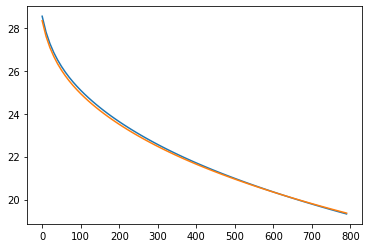

In [314]:
epochs = list(range(0, mlp.num_epochs, mlp.log_every_epoch))
plt.plot(epochs, loss_trn)
plt.plot(epochs, loss_val)

In [337]:
data_trn_1 = [x for x, y in data_trn]
data_val_1 = [x for x, y in data_val]
solver1 = Solver1(input_range=200, num_epochs=30000, log_every_epoch=1000)
loss_trn_1, loss_val_1 = solver1.train(data_trn_1, data_val_1)

loss at epoch 0: 5.298315777566274, 5.298316218177764
loss at epoch 1000: 5.296220064544965, 5.29721066746695
loss at epoch 2000: 5.294209997602433, 5.296190696643664
loss at epoch 3000: 5.2922855241341, 5.295256343375052
loss at epoch 4000: 5.290446688619768, 5.294407642914796
loss at epoch 5000: 5.288693534646249, 5.2936446280632685
loss at epoch 6000: 5.2870261074963025, 5.2929673291277295
loss at epoch 7000: 5.28544442791207, 5.292375773882572
loss at epoch 8000: 5.2839485183208605, 5.29186998752966
loss at epoch 9000: 5.282538381750897, 5.291449992658802
loss at epoch 10000: 5.281214069570023, 5.291115809208388
loss at epoch 11000: 5.27997558177697, 5.290867454426218
loss at epoch 12000: 5.2788229339142285, 5.29070494283058
loss at epoch 13000: 5.277756160636803, 5.290628286171592
loss at epoch 14000: 5.276775261392743, 5.290637493392854
loss at epoch 15000: 5.275880184160361, 5.290732570593435
loss at epoch 16000: 5.275071055958133, 5.2909135209902605
loss at epoch 17000: 5.27434

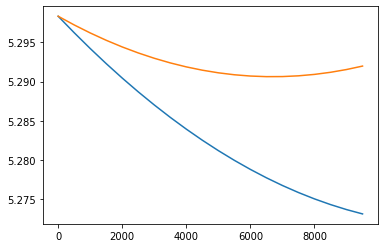

In [336]:
epochs = list(range(0, solver1.num_epochs, solver1.log_every_epoch))
plt.plot(epochs, loss_trn_1)
plt.plot(epochs, loss_val_1)

In [338]:
probs = np.exp(solver1.theta - np.max(solver1.theta))
probs /= np.sum(probs)
x_generated = np.random.choice(range(200), size=2000, replace=True, p=probs)
probs_table, _ = mlp.forward(np.array([mlp.one_hot(x) for x in x_generated]))
y_generated = [np.random.choice(range(200), size=1, p=probs)[0] for probs in probs_table]

(array([[14., 32., 32., 12., 32.,  5., 11.,  9., 21., 15.],
        [15.,  9., 13., 19., 10., 24., 30., 28., 14., 35.],
        [25., 16., 23.,  4., 23., 26., 22., 45.,  4., 13.],
        [11., 19., 12., 21., 15., 28., 25., 29., 37., 11.],
        [42., 16., 12., 16., 16., 18., 32., 32., 21., 11.],
        [33., 21., 16., 14., 28., 11., 17., 17., 32., 22.],
        [18., 16.,  7.,  6., 33., 40., 25., 36., 19.,  7.],
        [17., 31.,  6., 13., 23., 29., 21., 21., 10., 14.],
        [13., 34.,  9., 21., 28.,  9.,  9., 25., 42.,  7.],
        [21., 22., 19., 12., 22., 25., 23., 25., 14., 12.]]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <matplotlib.collections.QuadMesh at 0x11145a518>)

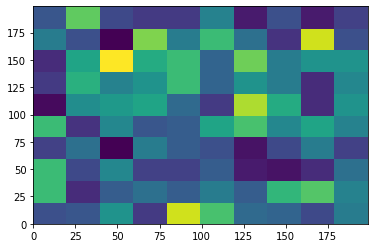

In [339]:
plt.hist2d(x_generated, y_generated)

(array([[ 916.,  867.,  837.,  717.,  629.,  745.,  696.,  803.,  805.,
          794.],
        [ 868.,  906.,  711.,  426.,  507.,  758.,  607.,  748.,  807.,
          812.],
        [ 885.,  907.,  450.,  614., 1256., 1527., 1714.,  823.,  805.,
          822.],
        [ 919.,  936.,  512., 1282., 1672., 1797., 1741., 1328.,  789.,
          792.],
        [ 942.,  944.,  659.,  960., 1456., 1143., 1242., 1673., 1174.,
          806.],
        [ 918.,  984.,  688., 1137., 1371., 1684., 1645., 1653., 1335.,
          736.],
        [ 906.,  914.,  810., 1108., 1063., 1736., 1747., 1589.,  896.,
          812.],
        [ 950.,  914.,  895.,  716., 1033., 1441., 1587., 1262.,  768.,
          792.],
        [ 881.,  940.,  831.,  653., 1225., 1460., 1378., 1156., 1019.,
          844.],
        [ 736.,  581.,  413.,  441.,  523., 1042., 1556.,  994.,  867.,
          841.]]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 array([  0. 

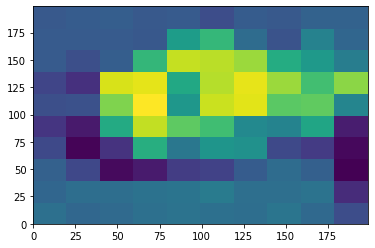

In [340]:
plt.hist2d([x for x, y in data_all], [y for x, y in data_all])

Solver1 should have been implemented as a special case of MLP with no hidden layer, where 
$$x^{(i)} = \emptyset, y^{(i)} = x, \forall x \in \{1 .. 100\}$$
$$\text{mlp_out} = \text{softmax}(\langle \text{one_hot}(\emptyset), \theta\rangle)$$
$$\text{target} = \text{one_hot}(x), \text{target}_i = I(i = x)$$
It encodes distribution with trivial prior $$p(x|\emptyset)$$

### 2.2 MADE